In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from glob import glob as glob
import os
import pywt
import cv2
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm

/Users/sukritarora/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# num_class = 15
# num_train = 20
# num_test = 5
im_size = np.array((192, 168))

In [3]:
def filter_files(d, num_train, num_test, cond):
    fnames = [os.path.basename(i)[:-4] for i in glob(d+"/*_P00A*.pgm")]
    acc_files = []
    for f in fnames:
        az = int(f[12:16])
        elev = int(f[17:20])
        if cond(az, elev):
            acc_files.append(f)
    samps = np.random.choice(acc_files, num_train+num_test, replace=False)
    return samps[:num_train], samps[num_train:]

def fread(f):
    return plt.imread(f).flatten().T

# def_cond = lambda az, elev: abs(az) <= 45 and abs(elev) <= 45
# def train_test_split(num_classes=5, num_train=5, num_test=3, cond = def_cond):
    
#     class_dirnames = np.random.choice(glob("CroppedYale/*"), size=num_classes, replace=False)
    
#     train_fnames_all, test_fnames_all = np.array([]), np.array([])
    
#     A = np.zeros((np.prod(im_size), num_classes*num_train))
#     y = np.zeros((np.prod(im_size), num_classes*num_test))
    
#     train_gt = np.zeros(num_classes*num_train).astype(int)
#     test_gt = np.zeros(num_classes*num_test).astype(int)
    
#     for i, d in enumerate(class_dirnames):
#         train_fnames, test_fnames = filter_files(d, num_train, num_test, cond)
#         train_fnames_all = np.append(train_fnames_all, train_fnames)
#         test_fnames_all = np.append(test_fnames_all, test_fnames)
#         for j, f in enumerate(train_fnames):
#             idx = (i*num_train+j)
#             A[:,idx] = fread(d+"/"+f+".pgm")
#             train_gt[idx] = i
#         for j, f in enumerate(test_fnames):
#             idx = (i*num_test+j) 
#             y[:,idx] = fread(d+"/"+f+".pgm")
#             test_gt[idx] = i
            
#     return A, y, train_gt, test_gt, (train_fnames_all, test_fnames_all)

def random_sample():
    all_fnames = glob("*/*/*_P00A*.pgm")
    half = len(all_fnames)//2
    np.random.shuffle(all_fnames)
    
    train_fnames = all_fnames[:half]
    test_fnames = all_fnames[half:]
    
    A = np.zeros((np.prod(im_size), len(train_fnames)))
    y = np.zeros((np.prod(im_size), len(test_fnames)))
    
    train_gt = np.zeros(len(train_fnames)).astype(int)
    test_gt = np.zeros(len(test_fnames)).astype(int)
    
    for i, f in enumerate(train_fnames):
        A[:,i] = fread(f)
        train_gt[i] = int(os.path.basename(f)[5:7])-1
        
    for i, f in enumerate(test_fnames):
        y[:,i] = fread(f)
        test_gt[i] = int(os.path.basename(f)[5:7])-1
        
    return A, y, train_gt, test_gt, (train_fnames, test_fnames)

In [4]:
A, y, train_gt, test_gt, names = random_sample()
print(A.shape, y.shape)
print(train_gt)
print(test_gt)

(32256, 1207) (32256, 1207)
[26  5  6 ... 23 18 35]
[23  1  9 ... 16 14 34]


In [198]:
names[1]

['CroppedYale/yaleB05/yaleB05_P00A-085E-20.pgm',
 'CroppedYale/yaleB27/yaleB27_P00A+000E-35.pgm',
 'CroppedYale/yaleB09/yaleB09_P00A+000E-35.pgm',
 'CroppedYale/yaleB06/yaleB06_P00A+025E+00.pgm',
 'CroppedYale/yaleB34/yaleB34_P00A-110E-20.pgm',
 'CroppedYale/yaleB26/yaleB26_P00A+000E+90.pgm',
 'CroppedYale/yaleB26/yaleB26_P00A-005E-10.pgm',
 'CroppedYale/yaleB10/yaleB10_P00A-070E+00.pgm',
 'CroppedYale/yaleB04/yaleB04_P00A-095E+00.pgm',
 'CroppedYale/yaleB04/yaleB04_P00A+110E+40.pgm',
 'CroppedYale/yaleB28/yaleB28_P00A-025E+00.pgm',
 'CroppedYale/yaleB32/yaleB32_P00A+000E+90.pgm',
 'CroppedYale/yaleB07/yaleB07_P00A+050E-40.pgm',
 'CroppedYale/yaleB13/yaleB13_P00A+110E+40.pgm',
 'CroppedYale/yaleB08/yaleB08_P00A+110E+40.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+050E+00.pgm',
 'CroppedYale/yaleB22/yaleB22_P00A+000E+20.pgm',
 'CroppedYale/yaleB15/yaleB15_P00A-120E+00.pgm',
 'CroppedYale/yaleB28/yaleB28_P00A-010E+00.pgm',
 'CroppedYale/yaleB07/yaleB07_P00A-110E-20.pgm',
 'CroppedYale/yaleB0

In [71]:
# A, y, train_gt, test_gt, names = train_test_split(num_classes = num_class, num_train = num_train, num_test = num_test)
# print(A.shape, y.shape)
# print(train_gt)
# print(test_gt)

(32256, 300) (32256, 75)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14]
[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3 

In [5]:
def down_samp(A, ds_factor=16):
    im_size_down = np.ceil(im_size/ds_factor).astype(int)
    A_down = np.zeros((np.prod(im_size_down), A.shape[-1]))
#     print(A_down.shape)
    for i in range(A.shape[-1]):
        A_down[:,i] = A[:,i].reshape(im_size)[::ds_factor, ::ds_factor].flatten()
    return A_down, im_size_down

In [6]:
def down_samp_pca(A, dim=132):
    # sklearn PCA
    pca = PCA(n_components=dim, svd_solver="auto")
    A_pca = pca.fit_transform(A.T).T
    
    # Manual PCA
#     U, S, Vh = np.linalg.svd(A, full_matrices=True)
#     print(U.shape, S.shape, Vh.shape)
#     A_pca = U[:,:dim].T@A
    return A_pca, pca

In [7]:
def down_samp_wave(A):
    im_vec = A.reshape((*im_size,-1))
    wave_vec = pywt.wavedec2(im_vec, 'haar', axes=(0,1), level=4)
#     low_dim_data = wave_vec[0]
    low_dim_data = wave_vec[0] + sum(wave_vec[1])
    return low_dim_data.reshape(-1, A.shape[-1]), low_dim_data.shape[:2]

In [8]:
def down_samp_cv(A):
    A_down = np.zeros((120, A.shape[-1]))
    for i in range(A.shape[-1]):
        A_down[:,i] = cv2.resize(A[:,i].reshape(im_size), (12,10)).flatten()
    return A_down, (12,10)

In [165]:
A_ds, ds_shape = down_samp(A, ds_factor=16)

In [76]:
A_wave, wave_shape = down_samp_wave(A)

In [158]:
A_ds_cv, ds_cv_shape = down_samp_cv(A)

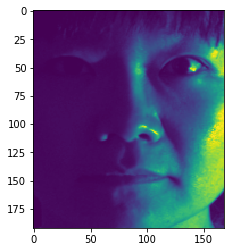

In [163]:
plt.imshow(A[...,0].reshape(im_size))

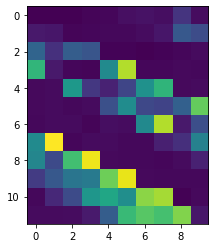

In [164]:
plt.imshow(A_ds_cv[...,0].reshape(ds_cv_shape))

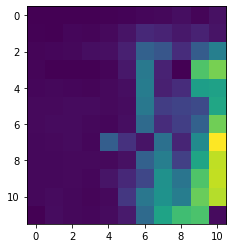

In [167]:
plt.imshow(A_ds[...,0].reshape(ds_shape))

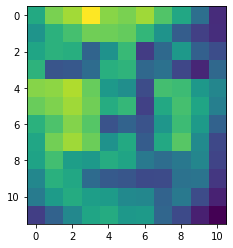

In [78]:
plt.imshow(A_wave[...,3].reshape(wave_shape))

In [79]:
A_pca, _ = down_samp_pca(A)

In [80]:
A_pca.shape

(25, 300)

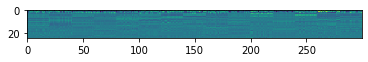

In [82]:
plt.imshow(A_pca)

In [8]:
# def delta(x, i):
#     assert i < num_class
#     out = np.zeros(len(x))
#     idxs = slice(i*num_class, i*num_class+num_train)
#     out[idxs] = x[idxs]
#     return out

In [9]:
def delta_i(x, i, gt):
    return np.where(gt==i, x, 0)

In [10]:
min(test_gt)

0

In [11]:
@ignore_warnings(category=ConvergenceWarning)
def identity(A, y, class_idxs):
    A_norm = np.linalg.norm(A, axis=0)
    y_norm = np.linalg.norm(y)
#     print(A, y)
    prob = Lasso(fit_intercept=False, alpha=1e-4, max_iter=1e3)
#     prob = LassoCV(fit_intercept=False, max_iter=1e4)
    prob.fit(A/A_norm, y/y_norm)
    x_hat = prob.coef_
    r = np.zeros(39)
    for i in range(39):
        r[i] = np.linalg.norm(y-A@delta_i(x_hat, i, class_idxs))
#     print(x_hat)
    return np.argmin(r)

In [12]:
np.linalg.norm(A, axis=0).shape

(1207,)

In [13]:
@ignore_warnings(category=ConvergenceWarning)
def robust_identity(A, y, class_idxs):
#     A_norm = np.linalg.norm(A, axis=0)
    y_norm = np.linalg.norm(y)
    m,n = A.shape
    B = np.hstack((A, np.eye(m)))
    B_norm = np.linalg.norm(B, axis=0)
#     print(B.shape)
    prob = Lasso(fit_intercept=False, alpha=1e-4)
    prob.fit(B/B_norm, y/y_norm)
    w_hat = prob.coef_
    x_hat = w_hat[:n]
    e_hat = w_hat[n:]
    r = np.zeros(39)
    for i in range(39):
        r[i] = np.linalg.norm(y-e_hat-A@delta_i(x_hat, i, class_idxs))
#     print(r-np.min(r))
    return np.argmin(r)

In [14]:
def evaluate(A, y, train_gt, test_gt, ld_func=down_samp, robust=False):
    train_pred = np.ones_like(train_gt)*-1
    test_pred = np.ones_like(test_gt)*-1
    
    if ld_func.__name__ == "down_samp_pca":
        A_ld, pca = ld_func(A)
        y_ld = pca.transform(y.T).T
    else:
        A_ld, _ = ld_func(A)
        y_ld, _ = ld_func(y)
    
#     print(A_ld.shape, y_ld.shape)
    for i in tqdm(range(len(train_pred))):
        if robust:
            train_pred[i] = robust_identity(A_ld, A_ld[:,i], train_gt)
        else:
            train_pred[i] = identity(A_ld, A_ld[:,i], train_gt)
#         print(train_pred[i], train_gt[i])
    
    for i in tqdm(range(len(test_pred))):
        if robust:
            test_pred[i] = robust_identity(A_ld, y_ld[:,i], train_gt)
        else:
            test_pred[i] = identity(A_ld, y_ld[:,i], train_gt)
    
#     print(train_pred)
    train_acc = accuracy_score(train_gt, train_pred)*100
    test_acc = accuracy_score(test_gt, test_pred)*100
    
    print("Accuracy for {}:\n\tTrain Accuracy: {:.2f}\n\tTest Accuracy: {:.2f}".format(ld_func.__name__, train_acc, test_acc))

In [15]:
down_samp_funcs = [down_samp, down_samp_wave,  down_samp_pca]

In [24]:
for func in down_samp_funcs:
    evaluate(A, y, train_gt, test_gt, ld_func=func)

  1%|          | 10/1207 [00:00<00:12, 93.70it/s]

(132, 1207) (132, 1207)


100%|██████████| 1207/1207 [00:47<00:00, 25.57it/s]


Accuracy for down_samp:
	Train Accuracy: 100.00
	Test Accuracy: 90.47


  1%|          | 7/1207 [00:00<00:19, 63.13it/s]

(132, 1207) (132, 1207)


100%|██████████| 1207/1207 [00:50<00:00, 23.89it/s]


Accuracy for down_samp_wave:
	Train Accuracy: 100.00
	Test Accuracy: 91.47


  1%|          | 15/1207 [00:00<00:08, 142.38it/s]

(132, 1207) (132, 1207)


100%|██████████| 1207/1207 [00:36<00:00, 32.97it/s]

Accuracy for down_samp_pca:
	Train Accuracy: 99.75
	Test Accuracy: 90.80


In [35]:
# Corrupt data for robust identity
def corrupt(test_mat, percent=0.3):
    im_size, num_ims = test_mat.shape
    corrupt_mat = test_mat.copy()
    corrupt_size = int(im_size*percent)
    for i in range(num_ims):
        corrupt_idxs = np.random.choice(im_size, size=corrupt_size, replace=False)
        corrupt_data = np.random.randint(256, size=corrupt_size)
        corrupt_mat[:,i][corrupt_idxs] = corrupt_data
#     print(im_size, num_ims, corrupt_size)
    return corrupt_mat

In [37]:
y_ds, y_ds_sh = down_samp(y, 2)

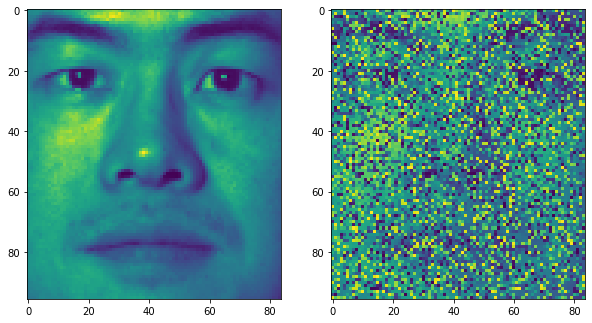

In [40]:
corrupt_y = corrupt(y_ds, 0.6)
k = 1
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(y_ds[:,k].reshape(y_ds_sh))
plt.subplot(122)
plt.imshow(corrupt_y[:,k].reshape(y_ds_sh))
plt.show()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
def evaluate_robust(A, y, train_gt, test_gt, ld_func=down_samp):
    
    test_pred = np.ones_like(test_gt)*-1
    
    if ld_func.__name__ == "down_samp_pca":
        A_ld, pca = ld_func(A)
        y_ld = pca.transform(y.T).T
    else:
        A_ld, _ = ld_func(A)
        y_ld, _ = ld_func(y)
    
#     print(A_ld.shape, y_ld.shape)
#     for i in tqdm(range(len(train_pred))):
#         train_pred[i] = robust_identity(A_ld, A_ld[:,i], train_gt)
#         print(train_pred[i], train_gt[i])
    corrupt_percs = np.arange(0,1,0.1)
    test_acc = []
    for perc in corrupt_pers:
        corrupt_y = corrupt(y_ld, perc)
        for i in tqdm(range(len(test_pred))):
            test_pred[i] = robust_identity(A_ld, corrupt_y[:,i], train_gt)

    #     print(train_pred)
        test_acc.append(accuracy_score(test_gt, test_pred)*100)
    
    print("Robust Identity Accuracy for {}:\n\tTest Accuracy: {}".format(ld_func.__name__, test_acc))
    return test_acc

In [34]:
#TODO: Change train and test data for robust
#TODO: Change ds factor for robust

test_accs = []
for func in down_samp_funcs:
    test_accs.append(evaluate_robust(A, y, train_gt, test_gt, ld_func=func))

100%|██████████| 1207/1207 [00:50<00:00, 23.67it/s]


Accuracy for down_samp:
	Train Accuracy: 100.00
	Test Accuracy: 88.32


100%|██████████| 1207/1207 [00:59<00:00, 20.46it/s]


Accuracy for down_samp_wave:
	Train Accuracy: 100.00
	Test Accuracy: 88.15


100%|██████████| 1207/1207 [00:46<00:00, 25.88it/s]

Accuracy for down_samp_pca:
	Train Accuracy: 99.75
	Test Accuracy: 90.22
